C:\Users\jesus\AppData\Local\Temp\ipykernel_38280\2392124220.py:51: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_clients.groupby(["age_bin", "variation"], as_index=False)["cost_effective"]


=== Cost-Effectiveness Rate por rango de Edad y Grupo ===
  age_bin variation  cost_effective
0     <35   Control        0.404229
1     <35      Test        0.448282
2   35-55   Control        0.454755
3   35-55      Test        0.473543
4     >55   Control        0.371231
5     >55      Test        0.401430

=== Análisis de Cost-Effectiveness Rate por rango de Edad ===

Rango de Edad: <35
   CE Rate (Test)    = 44.828%
   CE Rate (Control) = 40.423%
   z-stat = 4.6119, p-value = 0.000004
   -> Diferencia significativa (rechazamos H0).
   [Test: 2648 de 5907 clientes]
   [Control: 1988 de 4918 clientes]

Rango de Edad: 35-55
   CE Rate (Test)    = 47.354%
   CE Rate (Control) = 45.475%
   z-stat = 2.1547, p-value = 0.031183
   -> Diferencia significativa (rechazamos H0).
   [Test: 3356 de 7087 clientes]
   [Control: 2764 de 6078 clientes]

Rango de Edad: >55
   CE Rate (Test)    = 40.143%
   CE Rate (Control) = 37.123%
   z-stat = 3.2790, p-value = 0.001042
   -> Diferencia significati

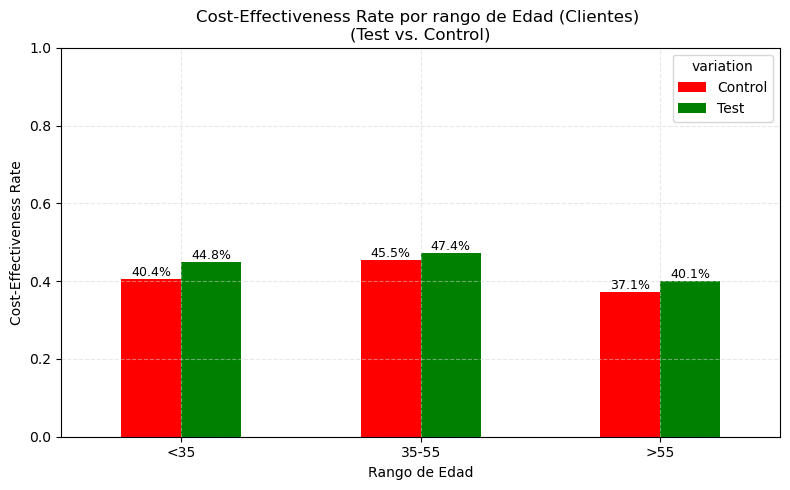

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

# --------------------------------------------------
# PASO 1: Cargar el DataFrame ya procesado
# --------------------------------------------------
df = pd.read_csv("../../data/processed/navegacion_clientes_experimento_limpio.csv")

# --------------------------------------------------
# PASO 2: Definir si el cliente completó el proceso (llegó a 'confirm')
# --------------------------------------------------
# Se marca True si process_step es "confirm", de lo contrario False.
df["completed"] = df["process_step"] == "confirm"

# --------------------------------------------------
# PASO 3: Agrupar a nivel de cliente (client_id) y variation
# --------------------------------------------------
# Cada cliente cuenta una sola vez; usamos max() para 'completed' y 'first' para 'clnt_age'.
df_clients = (
    df.groupby(["variation", "client_id"], as_index=False)
      .agg({
          "completed": "max",
          "calls_6_mnth": "first",
          "clnt_age": "first"
      })
)

# Filtrar para incluir sólo "Control" y "Test"
df_clients = df_clients[df_clients["variation"].isin(["Control", "Test"])].copy()

# --------------------------------------------------
# PASO 4: Definir el umbral de coste y crear la variable "cost_effective"
# --------------------------------------------------
# Se considera rentable (cost-effective) al cliente si completó el proceso y realizó <= threshold_calls.
threshold_calls = 3
df_clients["cost_effective"] = df_clients["completed"] & (df_clients["calls_6_mnth"] <= threshold_calls)

# --------------------------------------------------
# PASO 5: Crear categorías de edad (rango) en el DataFrame de clientes
# --------------------------------------------------
bins = [0, 35, 55, 120]         # Definimos intervalos de edad
labels = ["<35", "35-55", ">55"]  # Etiquetas para cada intervalo
df_clients["age_bin"] = pd.cut(df_clients["clnt_age"], bins=bins, labels=labels, include_lowest=True)

# --------------------------------------------------
# PASO 6: Calcular el Cost-Effectiveness Rate (CE Rate) por rango de edad y grupo
# --------------------------------------------------
df_ce_by_age = (
    df_clients.groupby(["age_bin", "variation"], as_index=False)["cost_effective"]
    .mean()  # La media equivale a la tasa de éxito rentable en cada segmento
)

print("=== Cost-Effectiveness Rate por rango de Edad y Grupo ===")
print(df_ce_by_age)

# --------------------------------------------------
# PASO 7: Test de hipótesis segmentado por rango de edad
# --------------------------------------------------
def proportion_test_for_age(seg_df):
    """
    Dado un DataFrame filtrado a un rango de edad,
    realiza un test de dos proporciones para comparar la tasa de éxito rentable
    (cost_effective) entre los grupos Test y Control.
    """
    summary = seg_df.groupby("variation")["cost_effective"].agg(["mean", "sum", "count"])
    if not {"Test", "Control"}.issubset(summary.index):
        return None
    test_sum = summary.loc["Test", "sum"]
    test_n   = summary.loc["Test", "count"]
    ctrl_sum = summary.loc["Control", "sum"]
    ctrl_n   = summary.loc["Control", "count"]
    
    count = np.array([test_sum, ctrl_sum])
    nobs  = np.array([test_n, ctrl_n])
    stat, p_value = sm.stats.proportions_ztest(count, nobs, alternative='two-sided')
    
    return {
        "CE_Test":    summary.loc["Test", "mean"],
        "CE_Control": summary.loc["Control", "mean"],
        "z_stat":     stat,
        "p_value":    p_value,
        "test_sum":   test_sum,
        "test_n":     test_n,
        "ctrl_sum":   ctrl_sum,
        "ctrl_n":     ctrl_n
    }

alpha = 0.05
age_bins_unique = df_clients["age_bin"].unique()

print("\n=== Análisis de Cost-Effectiveness Rate por rango de Edad ===\n")
for age_bin in age_bins_unique:
    if pd.isna(age_bin):
        continue
    seg_df = df_clients[df_clients["age_bin"] == age_bin]
    result = proportion_test_for_age(seg_df)
    if result is None:
        print(f"Rango de Edad {age_bin}: Datos insuficientes para Test o Control.")
        continue
    print(f"Rango de Edad: {age_bin}")
    print(f"   CE Rate (Test)    = {result['CE_Test']:.3%}")
    print(f"   CE Rate (Control) = {result['CE_Control']:.3%}")
    print(f"   z-stat = {result['z_stat']:.4f}, p-value = {result['p_value']:.6f}")
    if result["p_value"] < alpha:
        print("   -> Diferencia significativa (rechazamos H0).")
    else:
        print("   -> No hay diferencia significativa (no rechazamos H0).")
    print(f"   [Test: {int(result['test_sum'])} de {int(result['test_n'])} clientes]")
    print(f"   [Control: {int(result['ctrl_sum'])} de {int(result['ctrl_n'])} clientes]\n")

# --------------------------------------------------
# PASO 8: Graficar el Cost-Effectiveness Rate por rango de Edad a nivel de Cliente
# --------------------------------------------------
# Convertir a tabla dinámica para facilitar la visualización: filas = age_bin, columnas = variation.
df_pivot = df_ce_by_age.pivot(index="age_bin", columns="variation", values="cost_effective")

# Definir colores personalizados: Control en rojo, Test en verde, Unknown en gris (por si existiera).
color_map = {"Control": "red", "Test": "green", "Unknown": "gray"}
colors = [color_map.get(col, "gray") for col in df_pivot.columns]

fig, ax = plt.subplots(figsize=(8, 5))
df_pivot.plot(
    kind="bar",
    ax=ax,
    color=colors,
    legend=True
)

ax.set_title("Cost-Effectiveness Rate por rango de Edad (Clientes) \n(Test vs. Control)")
ax.set_xlabel("Rango de Edad")
ax.set_ylabel("Cost-Effectiveness Rate")
ax.set_ylim(0, 1)

# Añadir rejilla de líneas discontinuas grises
ax.grid(True, which='major', axis='both', color='lightgray', linestyle='--', alpha=0.5)

# Añadir etiquetas de porcentaje encima de cada barra
for p in ax.patches:
    height = p.get_height()
    if not np.isnan(height):
        ax.annotate(f"{height:.1%}",
                    (p.get_x() + p.get_width()/2, height),
                    ha="center", va="bottom", fontsize=9)

plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig("../../img/ce_by_age.jpg", dpi=300, bbox_inches='tight')
plt.show()
